
# Simulation von Magnetfeldrauschen eines zwei Level Trapped Ions

Dieses Notebook enthält die ersten Versuche einer Simulation von Magnetfeldrauschen für ein zwei Level System eines Trapped Ion Quantencomputers. 

## Rabi-Oszillation + 50Hz Rauschen

Als ersten Versuch der Darstellung wird lediglich ein Rauschen zu den Rabi-Daten hiinzuaddiert. In diesem Fall 50Hz, um Rauschen in einem Labor nachzuahmen.
Die Wahrscheinlichkeit, den Zustand $|\uparrow\rangle$ zu messen:

$$
P_\uparrow(t) = \frac{1}{2}\left(1 + e^{-t/T_2}\cos(\Omega_R t)\right) + Noise
$$




Fit-Parameter:
A     = 0.5004 ± 0.0061
Omega = 1.2000 ± 0.0027
T2    = 4.9943 ± 0.1019
C     = -0.0004 ± 0.0065


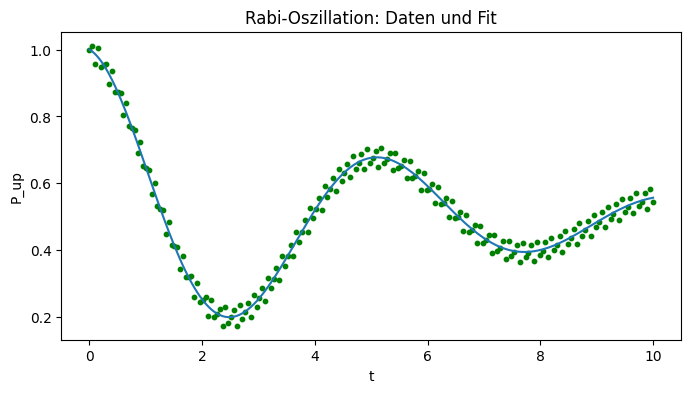

In [100]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Rabi Modell Funktion
def rabi_model(t, A, Omega, T2, C): # Modellfunktion für Rabi-Oszillation mit Dämpfung
    return A * (1 + np.exp(-t/T2) * np.cos(Omega * t)) + C

# Daten
np.random.seed(1234)
t = np.linspace(0, 10, 200)
A_true, Omega_true, T2_true, C_true = 0.5, 1.2, 5.0, 0.0

P = rabi_model(t, A_true, Omega_true, T2_true, C_true)
noise = 0.03*np.sin(50* t)
P_noisy = P + noise #hier wird ledeiglich Rauschen hinzuaddiert

# Fit Funktion auf die Daten anwenden
p0 = [0.4, 1.0, 4.0, 0.0]  # Startwerte
popt, pcov = curve_fit(rabi_model, t, P_noisy, p0=p0)
perr = np.sqrt(np.diag(pcov))

A_fit, Omega_fit, T2_fit, C_fit = popt
A_err, Omega_err, T2_err, C_err = perr

# Ergebnisse der Fit Parameter ausgeben
print("Fit-Parameter:")
print(f"A     = {A_fit:.4f} ± {A_err:.4f}")
print(f"Omega = {Omega_fit:.4f} ± {Omega_err:.4f}")
print(f"T2    = {T2_fit:.4f} ± {T2_err:.4f}")
print(f"C     = {C_fit:.4f} ± {C_err:.4f}")

# Plot
plt.figure(figsize=(8,4))
plt.scatter(t, P_noisy, s=10, color='green')
plt.plot(t, rabi_model(t, *popt))
plt.xlabel("t")
plt.ylabel("P_up")
plt.title("Rabi-Oszillation: Daten und Fit")
plt.show()


Hierbei wird sichtbar, dass man diese Art von Rauschen noch sehr gut mithilfe einer Fit Funktion bereinigen kann. 

## Rabi Oszillation mit Ornstein Uhlenbeck Rauschen ##

Jedoch entspricht dies nicht wirklich der Realität. Magnetfeldrauschen $\Delta (t)$ erzeugt Frequenzrauschen $\delta \omega (t)$, woraus durch Zeitentwicklung eine akkumulierte Phase entsteht: $ \phi= \int_{t_0}^{t_0+\tau} \Delta(t) dt$ Als nächstes wird die das Rauschen direkt in die Simulation der Rabi-Frequenz miteingerechnet. Dies geschieht mithilfe eines Ornstein Uhlenbeck Prozesses, wodurch normalverteiltes Rauschen simuliert werden kann. Dieser Prozess wird wie folgt implementiert: $dx(t) = -\theta x(t) dt+ \sigma dW(t)$

x(t) ist in diesem Fall das Rauschen, sprich: $\delta \omega$
dW(t) ist die Gaussche Variable zwischen 0 und 1.
$\sigma$ ist die Amplitude des Rauschens

$\theta$ ist die "Reversion rate" - wie schnell das Rauschen zu 0 abfällt

Fit-Parameter:
A     = 0.5182 ± 0.0252
Omega = 1.2528 ± 0.0127
T2    = 4.3139 ± 0.3326
C     = 0.0204 ± 0.0267


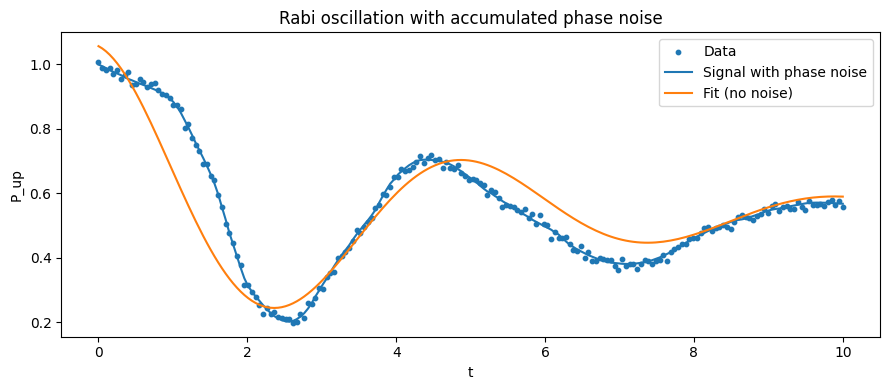

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Ornstein Uhlenbeck Noise Funktion
def ou_noise(dt, steps, theta=1.0, sigma=0.2):
    x = np.zeros(steps)
    for i in range(1, steps):
        x[i] = x[i-1] + (-theta*x[i-1])*dt + sigma*np.sqrt(dt)*np.random.randn()
    return x

# Rabi Model inkl. Phi (akkumulierte Phase)
def rabi_noisy(t, A, Omega, T2, C, phi):
    return A * (1 + np.exp(-t/T2) * np.cos(Omega * t + phi)) + C


np.random.seed(23994)

# Parameter
A_true, Omega_true, T2_true, C_true = 0.5, 1.2, 5.0, 0.0
t = np.linspace(0, 10, 200)
dt = t[1] - t[0]

# Ornstein Uhlenbeck Rauschen δω(t)
dw = ou_noise(dt, len(t), theta=1.0, sigma=1.0)

# Akkumulierte Phase φ(t) = ∫ δω(t') dt'
phi = np.cumsum(dw) * dt

# Rabi ohne Noise
P = rabi_noisy(t, A_true, Omega_true, T2_true, C_true, phi)

# Optionales Messrauschen hinzufügen
P_noisy = P + 0.01*np.random.randn(len(t))

# Fit Funktion ohne akkumulierte Phase
# T2 wird so angepasst, dass der Effekt des Rauschens teilweise kompensiert wird
def rabi_model_fit(t, A, Omega, T2, C):
    return A * (1 + np.exp(-t/T2) * np.cos(Omega * t)) + C

p0 = [0.4, 1.0, 4.0, 0.0]
popt, pcov = curve_fit(rabi_model_fit, t, P_noisy, p0=p0)
perr = np.sqrt(np.diag(pcov))

A_fit, Omega_fit, T2_fit, C_fit = popt
A_err, Omega_err, T2_err, C_err = perr

#Ergebnisse der Fit Parameter ausgeben
print("Fit-Parameter:")
print(f"A     = {A_fit:.4f} ± {A_err:.4f}")
print(f"Omega = {Omega_fit:.4f} ± {Omega_err:.4f}")
print(f"T2    = {T2_fit:.4f} ± {T2_err:.4f}")
print(f"C     = {C_fit:.4f} ± {C_err:.4f}")

# Plot
plt.figure(figsize=(9,4))
plt.scatter(t, P_noisy, s=10, label="Data")
plt.plot(t, P, label="Signal with phase noise")
plt.plot(t, rabi_model_fit(t, *popt), label="Fit (no noise)")
plt.xlabel("t")
plt.ylabel("P_up")
plt.title("Rabi oscillation with accumulated phase noise")
plt.legend()
plt.tight_layout()
plt.show()


## Ramsey Experiment ##

Für die 
Simulation des kompletten Ramsey Experiments mit Quiskit:

A = 1.0829130806750502
T2 = 8.266877808981944
omega = 1.0037002512551214
phi0 = -0.03982435825885432
C = -0.0031186489503375924


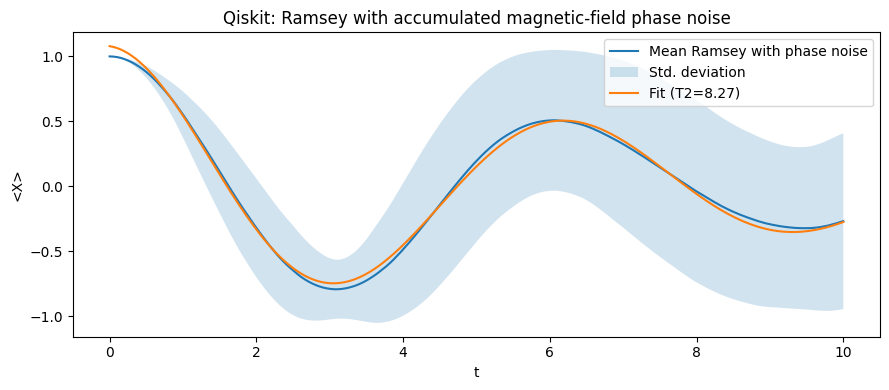

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Pauli
from scipy.optimize import curve_fit


# Rauschfunktion: Ornstein Uhlenbeck Prozess
def ou_noise(dt, steps, theta=1.0, sigma=0.6):
    x = np.zeros(steps)
    for i in range(1, steps):
        x[i] = x[i-1] + (-theta*x[i-1])*dt + sigma*np.sqrt(dt)*np.random.randn()
    return x


# Ramsey-Schaltkreis mit akkumuliertem Phasenrauschen
def ramsey_phase(phi):
    qc = QuantumCircuit(1)
    qc.ry(np.pi/2, 0) # Erstes Hadamard
    qc.rz(phi, 0)   # Akkumulierter Phase aus B-Feld Rauschen
    qc.rx(np.pi/2,0) # Hadamard mit Phasenverschiebung
    return qc


# Expectation value des Pauli X berechnen
def exp_X(state):
    X = Pauli("X")
    return state.expectation_value(X).real


# Parameter für die Simulation
np.random.seed(1234)

T = np.linspace(0, 10, 200)
dt = T[1]-T[0]

num_runs = 100            # Anzahl der Simulationen für Mittelwertbildung



all_signals = []
for _ in range(num_runs):
    #Rausch δω(t)
    dw = ou_noise(dt, len(T), theta=1.0, sigma=0.5)

    # akkumulierte Phase φ(t) + Rotationsfrequenz omega
    omega= 1.0 #rad/s 
    phi = omega * T + np.cumsum(dw) * dt


    # Quiskit
    signal = []
    for ph in phi:
        qc = ramsey_phase(ph)
        sv = Statevector.from_label("0").evolve(qc)
        signal.append(exp_X(sv))

    all_signals.append(signal)
all_signals = np.array(all_signals)
mean_signal = np.mean(all_signals, axis=0)
std_signal = np.std(all_signals, axis=0)


# Fit für T2 
def full_model(t, A, T2, omega, phi0, C):
    return A * np.exp(-t / T2) * np.cos(omega * t + phi0) + C

def full_model(t, A, T2, omega, phi0, C):
    return A * np.exp(-t / T2) * np.cos(omega * t + phi0) + C

# anfängliche Parameter schätzen
A0 = 1.0
T20 = 5.0
omega0 = 1.0           # Rabi Frequenz
phi00 = 0.0            # Afangsphase
C0 = 0.0               # Offset

# Curve Fit wie bisher

p0 = [A0, T20, omega0, phi00, C0]

popt, pcov = curve_fit(full_model, T, mean_signal, p0=p0)
A_fit, T2_fit, omega_fit, phi_fit, C_fit = popt

#Ausgabe der Fit Parameter
print("A =", A_fit)
print("T2 =", T2_fit)
print("omega =", omega_fit)
print("phi0 =", phi_fit)
print("C =", C_fit)

#Plot
plt.figure(figsize=(9,4))
plt.plot(T, mean_signal, label="Mean Ramsey with phase noise")

plt.fill_between(T, mean_signal - std_signal, mean_signal + std_signal, alpha=0.2, label="Std. deviation")

plt.plot(T, full_model(T, *popt), label=f"Fit (T2={T2_fit:.2f})")
plt.xlabel("t")
plt.ylabel("<X>")
plt.title("Qiskit: Ramsey with accumulated magnetic-field phase noise")
plt.legend()
plt.tight_layout()
plt.show()

### Hilbert Transformation ###

Eine weitere und robustere Möglichkeit zur Analyser der T2 Zeit kann die Hilber Transformation sein:

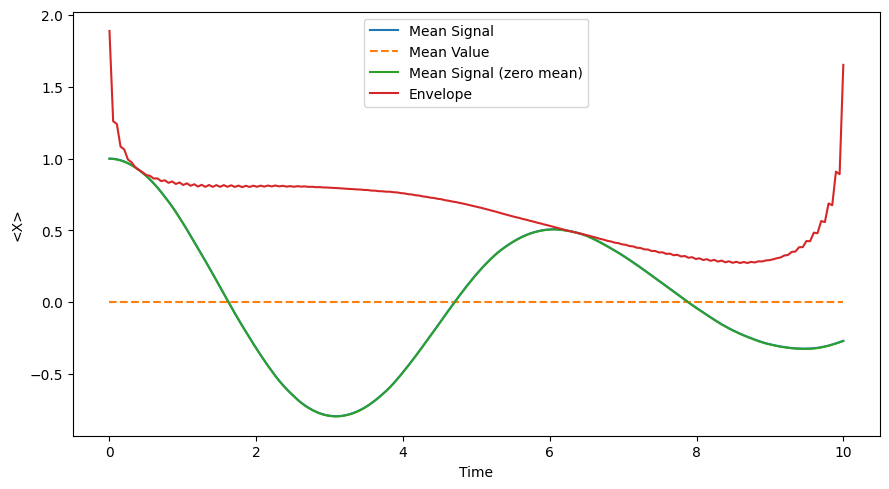

T2 (envelope) = 7.037430727198718


In [103]:
from scipy.signal import hilbert
from scipy.optimize import curve_fit
import numpy as np

# inputs: T (times), mean_signal (ensemble average)


# Frequenzanalyse via Hilbert-Transformation
analytic = hilbert(mean_signal - mean_signal.mean())
envelope = np.abs(analytic)

plt.figure(figsize=(9,5))

# 1) Durchschnittssignal aus vorheriger Zelle
plt.plot(T, mean_signal, label="Mean Signal")

# 2) Mittelwert
plt.plot(T, np.full_like(T, mean_signal.mean()), '--', label="Mean Value")

# 3) Zero-mean signal
plt.plot(T, mean_signal - mean_signal.mean(), label="Mean Signal (zero mean)")

# 4) Envelope
plt.plot(T, envelope, label="Envelope")

plt.xlabel("Time")
plt.ylabel("<X>")
plt.legend()
plt.tight_layout()
plt.show()

def env_exp(t, A, T2, C):
    return A * np.exp(-t / T2) + C

p0 = [envelope.max()-envelope.min(), (T[-1]-T[0])/3, envelope.min()]
popt, pcov = curve_fit(env_exp, T, envelope, p0=p0)
A_e, T2_e, C_e = popt
print("T2 (envelope) =", T2_e)


Hierbei ist die T2 Zeit jedoch etwas größer als die T2 Zeit bei nichtlinearen Least Spuares Fit zuvor.

### Bloch Vector Darstellung ###

Start Coords:  1.0 -2.220446049250313e-16 0.0
End Coords:  -0.47495267223788784 0.0 0.8800113403440263


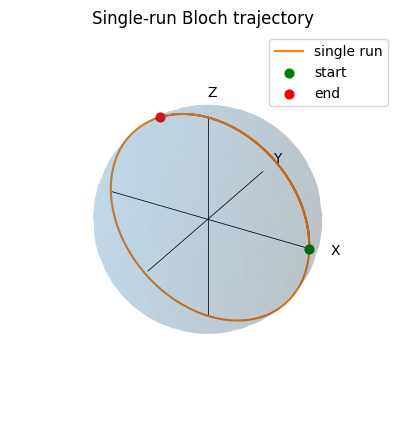

In [104]:
sigma_noise = 0.6

dw = ou_noise(dt, len(T), theta=1.0, sigma=sigma_noise)
phi_single = omega * T + np.cumsum(dw) * dt


X = Pauli("X")
Y = Pauli("Y")
Z = Pauli("Z")

def bloch_components(sv: Statevector):
    # returns (x, y, z) real floats
    x = sv.expectation_value(X).real
    y = sv.expectation_value(Y).real
    z = sv.expectation_value(Z).real
    return np.real_if_close([x, y, z]).astype(float)

bloch_traj = np.zeros((len(T), 3))
for i, ph in enumerate(phi_single):
    qc = ramsey_phase(ph)
    sv = Statevector.from_label("0").evolve(qc)
    bloch_traj[i] = bloch_components(sv)

def plot_bloch_sphere(ax, alpha=0.15):
    # draw a translucent unit sphere
    u = np.linspace(0, 2*np.pi, 60)
    v = np.linspace(0, np.pi, 30)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_surface(x, y, z, rstride=2, cstride=2, linewidth=0, alpha=alpha, zorder=0)
    # axes lines
    ax.plot([-1,1],[0,0],[0,0],'k-', lw=0.6)
    ax.plot([0,0],[-1,1],[0,0],'k-', lw=0.6)
    ax.plot([0,0],[0,0],[-1,1],'k-', lw=0.6)
    # labels
    ax.text(1.2, 0, 0, 'X', fontsize=10)
    ax.text(0, 1.2, 0, 'Y', fontsize=10)
    ax.text(0, 0, 1.2, 'Z', fontsize=10)
    ax.set_xlim([-1,1]); ax.set_ylim([-1,1]); ax.set_zlim([-1,1])
    ax.set_box_aspect((1,1,1))
    ax.axis('off')

fig = plt.figure(figsize=(12,5))

#  single-run trajectory on Bloch sphere
ax1 = fig.add_subplot(121, projection='3d')
plot_bloch_sphere(ax1)

# plot the path
ax1.plot(bloch_traj[:,0], bloch_traj[:,1], bloch_traj[:,2], lw=1.5, label='single run')
# mark start and end
ax1.scatter([bloch_traj[0,0]],[bloch_traj[0,1]],[bloch_traj[0,2]], color='green', s=40, label='start')
ax1.scatter([bloch_traj[-1,0]],[bloch_traj[-1,1]],[bloch_traj[-1,2]], color='red', s=40, label='end')
ax1.set_title('Single-run Bloch trajectory')

ax1.legend()
print("Start Coords: ", bloch_traj[0,0], bloch_traj[0,1], bloch_traj[0,2])
print("End Coords: ", bloch_traj[-1,0], bloch_traj[-1,1], bloch_traj[-1,2])